### Projeto - Classificação de imagens

Na disciplina são vistas diferentes técnicas de preprocessamento, bem como algoritmos de extração de features e como podemos utilizar técnicas de aprendizagem de máquina para classificar imagens.

Este projeto tem como objetivo consolidar os conhecimentos vistos na disciplina aplicando-os em um determinado problema


### A Base de dados

Para desenvolver o projeto, será utilizado o dataset [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Este dataset possui diferentes raças de cachorros e gatos, conforme ilustrado na figura baixo.

![Title](breeds.png)

Para essa base de dados,os conceitos vistos na disciplina deverão ser realizados para desenvolver duas soluções:

1 - Um classificador de gatos e cachorros

2 (bônus) - Um classificador de raças de animais 

OBS: O ponto 2, a princípio, deverá ser realizado com todas as raças de gatos e cachorros. Entretanto, caso desejem, podem dividir o problema em dois: uma para raças de gatos e outra para raças de cachorros. 

### Solução 1 - Classificador de gatos e cachorros

Para implementação dessa solução, as seguintes etapas deverão ser realizadas:

1 - Leitura da base de dados utilizando a biblioteca OpenCV

2 - Visualização de imagens do dataset. Como você avalia as imagens desta base de dados para cada classe? O quão difícil você considera esse problema visualmente?

3 - Quais as dimensões e quantos canais de cores possuem a imagem?

4 - Implemente um classificador para este problema. Qual o desempenho deste classificador? (escolha acurácia e outra métrica como F1 score, curva ROC, matriz de confusão)

5 - Preprocesse as imagens do dataset e realize novamente a etapa 4, compare os resultados com os obtidos anteriormente. Dentre as técnicas de pré-processamento, pode-se passar a imagem para tons de cinza, implementar filtros de aguçamento, suavização ou operações como equalização do histograma.

**Bônus:** Utilize um extrator de características (como SIFT ou SURF) e treine o classificador após este passo. O que você observa no desempenho do algoritmo?  

### Solução 2 - Classificar raças de animais

Repita os passos 1 a 5 da solução 1, porém, ao invés de um problema binário, a base de dados será utilizada para classificar raças de animais, sendo cada raça uma classe. 

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import RcParams
import cv2
import glob
import re
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pega o nome e o diretório da imagem

files = [file for file in glob.glob('/content/drive/MyDrive/data_sets/cats_dogs/images/*/*.jpg')]
files

['/content/drive/MyDrive/data_sets/cats_dogs/images/images/Bengal_146.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/shiba_inu_27.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/american_bulldog_175.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/boxer_35.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/chihuahua_61.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/beagle_32.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/pomeranian_193.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/japanese_chin_116.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/Egyptian_Mau_111.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/beagle_196.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/Maine_Coon_13.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/images/images/miniature_pinscher_36.jpg',
 '/content/drive/MyDrive/data_sets/cats_dogs/i

In [ ]:
# lê, converte para gray scale e salva em um diretório

for i, file in enumerate(files):
  try:
    img = cv2.imread(file) ### ler a imagem
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    label = file.split('/')[-1]
    cv2.imwrite('/content/drive/MyDrive/data_sets/cats_dogs/images/' + label +'.png', img_gray)
   
  except:
    print(label)

/content/drive/MyDrive/data_sets/cats_dogs/images/images/Egyptian_Mau_139.jpg
/content/drive/MyDrive/data_sets/cats_dogs/images/images/Egyptian_Mau_145.jpg
/content/drive/MyDrive/data_sets/cats_dogs/images/images/Egyptian_Mau_191.jpg
/content/drive/MyDrive/data_sets/cats_dogs/images/images/Egyptian_Mau_177.jpg
/content/drive/MyDrive/data_sets/cats_dogs/images/images/Egyptian_Mau_167.jpg
/content/drive/MyDrive/data_sets/cats_dogs/images/images/Abyssinian_34.jpg


In [4]:
# lê, cria dataset e label
dataset = []
labels = []
files = [file for file in glob.glob('/content/drive/MyDrive/data_sets/cats_dogs/images/*.png')]
files.sort()
for file in files:
    img = cv2.imread(file) ### ler a imagem
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
    label = file.split('/')[-1]
    labels.append(label)
  
    dataset.append(img_gray)

In [5]:
breeds = []
for i in range(0, len(labels)):

  label =re.split('\d', labels[i])[0][:-1]
  breeds.append(label.lower())
  
breeds = pd.Series(breeds)
breeds.unique()

array(['abyssinian', 'bengal', 'birman', 'bombay', 'british_shorthair',
       'egyptian_mau', 'maine_coon', 'persian', 'ragdoll', 'russian_blue',
       'siamese', 'sphynx', 'american_bulldog',
       'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer',
       'chihuahua', 'english_cocker_spaniel', 'english_setter',
       'german_shorthaired', 'great_pyrenees', 'havanese',
       'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher',
       'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed',
       'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier',
       'wheaten_terrier', 'yorkshire_terrier'], dtype=object)

In [6]:
breeds.value_counts(sort = False)

abyssinian                    199
bengal                        200
birman                        200
bombay                        200
british_shorthair             200
egyptian_mau                  195
maine_coon                    201
persian                       200
ragdoll                       200
russian_blue                  200
siamese                       200
sphynx                        200
american_bulldog              200
american_pit_bull_terrier     200
basset_hound                  200
beagle                        200
boxer                         200
chihuahua                     200
english_cocker_spaniel        200
english_setter                200
german_shorthaired            200
great_pyrenees                200
havanese                      200
japanese_chin                 200
keeshond                      200
leonberger                    201
miniature_pinscher            200
newfoundland                  200
pomeranian                    200
pug           

In [7]:
cats = ['abyssinian','egyptian_mau', 'birman', 'persian', 'bombay', 'british_shorthair',
        'russian_blue', 'bengal', 'siamese', 'ragdoll', 'sphynx', 'maine_coon']
dogs = (['pug', 'staffordshire_bull_terrier', 'scottish_terrier', 'havanese','miniature_pinscher', 
         'japanese_chin', 'pomeranian', 'beagle', 'chihuahua ', 'boxer', 'american_bulldog',
         'samoyed', 'shiba_inu', 'english_cocker_spaniel', 'newfoundland', 'basset_hound',
         'saint_bernard','wheaten_terrier', 'yorkshire_terrier', 'great_pyrenees', 'american_pit_bull_terrier', 
         'keeshond', 'english_setter', 'german_shorthaired', 'leonberger' ])

In [8]:
# create label: cat and dog

species = []
for i in breeds:
  if i in cats:
    species.append('cat')
  else:
    species.append('dog')

In [9]:
species = pd.Series(species)
species.value_counts()

dog    4991
cat    2395
dtype: int64

In [10]:
species.replace({'cat': 0, 'dog': 1}, inplace= True)

american_pit_bull_terrier


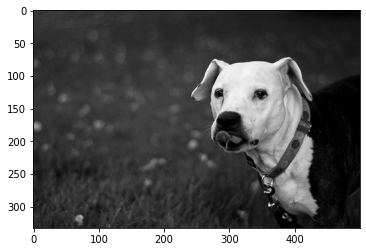

In [12]:
print(list(breeds)[2720])
plt.imshow(dataset[2720], cmap='gray');

In [6]:
def aplica_filtros(X, size= 64, changeShape= False):

  dataset = []

  for img in X:
    # img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.resize(img,(size, size),interpolation=cv2.INTER_LINEAR)
    img = cv2.Laplacian(img, cv2.CV_64F, ksize = 3)
    dataset.append(img)
  if changeShape:
    dataset = np.asarray([img.reshape(-1) for img in dataset]);

  return dataset

In [7]:
df = aplica_filtros(dataset, 128, True)

In [56]:

print('Original dataset shape %s' % Counter(species))

rus = RandomUnderSampler(random_state=42)

X_df, y_species = rus.fit_resample(df, species)

print('Resampled dataset shape %s' % Counter(y_species))

Original dataset shape Counter({1: 4991, 0: 2395})
Resampled dataset shape Counter({0: 2395, 1: 2395})


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_species, 
                                                    test_size=0.2, 
                                                    stratify=y_species, random_state=42)

print('tamanho do dataset de treino:', X_train.shape)
print('tamanho do dataset de teste:', X_test.shape)

tamanho do dataset de treino: (3832, 16384)
tamanho do dataset de teste: (958, 16384)


In [58]:
xgb_sp = XGBClassifier(max_depth = 1, n_jobs = -1)

xgb_sp.fit(X_train, y_train) 
y_pred_xgb = xgb_sp.predict(X_test)

In [27]:
def metricas_classificacao(estimator, X_train, X_test, y_train, y_test, RCD = False, sp=False):
    
    # ============================================
    print('#'*80)
    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)
    y_probs_train = estimator.predict_proba(X_train)[:, 1]

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)


    if sp:
      plt.xticks([0 , 1], ['cats', 'dogs'])
      plt.yticks([0 ,1], ['cats', 'dogs'])

    plt.show()

    print(classification_report(y_train, y_pred_train))
    print('#'*80)

    if RCD:
      disp = RocCurveDisplay.from_predictions(y_train, y_probs_train)
      disp.ax_.set_title(f"AUC: {roc_auc_score(y_train, y_probs_train):.3f}", fontsize=16)
      x = np.linspace(0, 1, 100)
      plt.plot(x, x, ls=":", color="black")
      plt.show()

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)
    y_probs_test = estimator.predict_proba(X_test)[:, 1]

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    if sp:
      plt.xticks([0 , 1], ['cats', 'dogs'])
      plt.yticks([0 ,1], ['cats', 'dogs'])
    
    plt.show()

    print(classification_report(y_test, y_pred_test))
    print('#'*80)
    if RCD:
      disp = RocCurveDisplay.from_predictions(y_test, y_probs_test)
      disp.ax_.set_title(f"AUC: {roc_auc_score(y_test, y_probs_test):.3f}", fontsize=16)
      x = np.linspace(0, 1, 100)
      plt.plot(x, x, ls=":", color="black")
      plt.show()


################################################################################

Métricas de avaliação de treino:


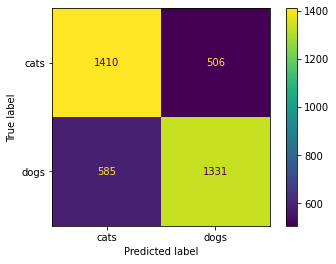

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      1916
           1       0.72      0.69      0.71      1916

    accuracy                           0.72      3832
   macro avg       0.72      0.72      0.72      3832
weighted avg       0.72      0.72      0.72      3832

################################################################################


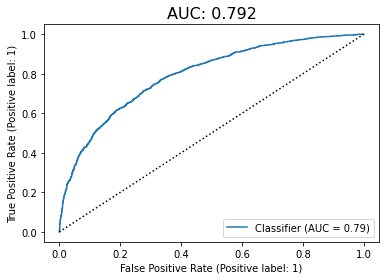


Métricas de avaliação de teste:


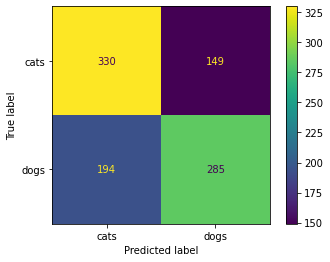

              precision    recall  f1-score   support

           0       0.63      0.69      0.66       479
           1       0.66      0.59      0.62       479

    accuracy                           0.64       958
   macro avg       0.64      0.64      0.64       958
weighted avg       0.64      0.64      0.64       958

################################################################################


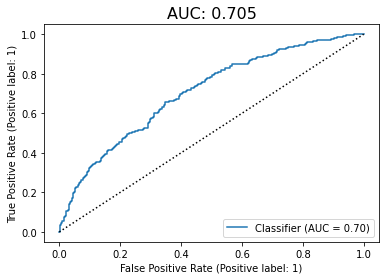

In [59]:
metricas_classificacao(xgb_sp, X_train, X_test, y_train, y_test, RCD = True, sp= True)

## Classificação de raças de gatos e cachorros

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df, breeds, 
                                                    test_size=0.2, 
                                                    stratify=breeds, random_state=42)

print('tamanho do dataset de treino:', X_train.shape)
print('tamanho do dataset de teste:', X_test.shape)

tamanho do dataset de treino: (5908, 16384)
tamanho do dataset de teste: (1478, 16384)


In [11]:
xgb_breeds = XGBClassifier(max_depth = 1, n_jobs = -1)

xgb_breeds.fit(X_train, y_train) 
y_pred_xgb = xgb_breeds.predict(X_test)

################################################################################

Métricas de avaliação de treino:


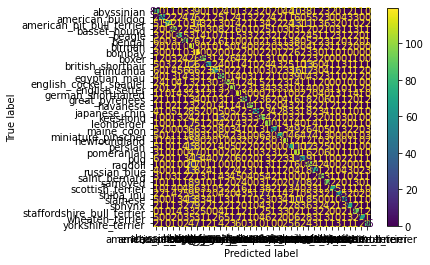

                            precision    recall  f1-score   support

                abyssinian       0.43      0.50      0.47       159
          american_bulldog       0.73      0.43      0.54       160
 american_pit_bull_terrier       0.76      0.34      0.47       160
              basset_hound       0.61      0.59      0.60       160
                    beagle       0.61      0.52      0.56       160
                    bengal       0.51      0.56      0.54       160
                    birman       0.33      0.67      0.44       160
                    bombay       0.37      0.74      0.49       160
                     boxer       0.62      0.59      0.61       160
         british_shorthair       0.51      0.38      0.44       160
                 chihuahua       0.71      0.34      0.46       160
              egyptian_mau       0.39      0.56      0.46       156
    english_cocker_spaniel       0.63      0.62      0.62       160
            english_setter       0.64      0.63

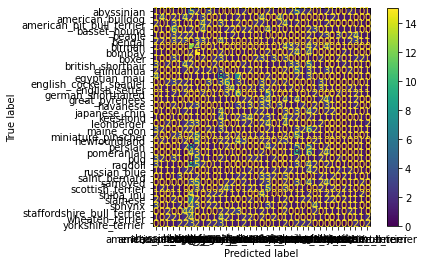

                            precision    recall  f1-score   support

                abyssinian       0.03      0.03      0.03        40
          american_bulldog       0.17      0.10      0.13        40
 american_pit_bull_terrier       0.05      0.03      0.03        40
              basset_hound       0.13      0.15      0.14        40
                    beagle       0.06      0.05      0.06        40
                    bengal       0.07      0.07      0.07        40
                    birman       0.12      0.30      0.17        40
                    bombay       0.19      0.38      0.25        40
                     boxer       0.07      0.05      0.06        40
         british_shorthair       0.00      0.00      0.00        40
                 chihuahua       0.00      0.00      0.00        40
              egyptian_mau       0.11      0.21      0.15        39
    english_cocker_spaniel       0.13      0.15      0.14        40
            english_setter       0.12      0.10

In [28]:
metricas_classificacao(xgb_breeds, X_train, X_test, y_train, y_test)